In [1]:
import sys
import numpy as np
from pathlib import Path
parent_dir = Path.cwd().parent
sys.path.append(str(parent_dir))
from instruments import *
from physical_models import *

In [2]:
# create a system dict for CHARIS

def generate_CHARIS_mueller_matrix(wavelength_bin, hwp_angle, imr_angle, beam):
    """ 
    Generate a pyMuellerMuellerMat matrix object for CHARIS based on the given
    wavelength bin, HWP angle, and derotator angle. Currently only works for lowres mode. 
    Based on Joost 't Hart 2021

    Parameters:
    -----------
    wavelength_bin : int
        The index of the wavelength bin, zero based. (0 to 21 for 22 bins)
    hwp_angle : float
        The rotation angle of the half-wave plate in degrees.
    imr_angle : float
        The angle of the image rotator in degrees.
    beam : str
        The beam type, either 'o' for ordinary or 'e' for extraordinary.
    Returns:
    --------
    sys_mm : pyMuellerMat.MuellerMatrix
        A Mueller matrix object representing the CHARIS system.
    """
    # check that it is in lowres mode

    if wavelength_bin < 0 or wavelength_bin > 21:
        raise ValueError("Wavelength bin must be between 0 and 21 for lowres mode.")
    
    # constants based on Joost 't Hart 2021

    offset_imr = -0.0118 # derotator offset
    offset_hwp = -0.002 # HWP offset
    offset_cal = -0.035 # calibration polarizer offset
    wavelength_bins = np.array([1159.5614, 1199.6971, 1241.2219, 1284.184 , 1328.6331, 1374.6208,
                1422.2002, 1471.4264, 1522.3565, 1575.0495, 1629.5663, 1685.9701,
                1744.3261, 1804.7021, 1867.1678, 1931.7956, 1998.6603, 2067.8395,
                2139.4131, 2213.4641, 2290.0781, 2369.3441])
    theta_imr = imr_angle
    theta_hwp = hwp_angle
    theta_cal = 0  # calibration polarizer angle
    hwp_retardances = HWP_retardance(wavelength_bins) # based on physical model
    imr_retardances = IMR_retardance(wavelength_bins) # based on physical model

    # create the system dictionary

    sys_dict = {
        "components" : {
            "wollaston" : {
            "type" : "wollaston_prism_function",
            "properties" : {"beam": beam},
            "tag": "internal",
            },
            "image_rotator" : {
                "type" : "general_retarder_function",
                "properties" : {"phi": imr_retardances[wavelength_bin], "theta": theta_imr + offset_imr},
                "tag": "internal",
            },
            "hwp" : {
                "type" : "general_retarder_function",
                "properties" : {"phi": hwp_retardances[wavelength_bin], "theta": theta_hwp + offset_hwp},
                "tag": "internal",
            },
            "lp" : {
                "type": "general_linear_polarizer_function_with_theta",
                "properties": {"theta": offset_cal + theta_cal},
                "tag": "internal",
            }}
    }

    # generate Mueller matrix object

    system_mm = generate_system_mueller_matrix(sys_dict)
    return system_mm


In [3]:
wavelength_bins = np.array([1159.5614, 1199.6971, 1241.2219, 1284.184 , 1328.6331, 1374.6208,
1422.2002, 1471.4264, 1522.3565, 1575.0495, 1629.5663, 1685.9701,
1744.3261, 1804.7021, 1867.1678, 1931.7956, 1998.6603, 2067.8395,
2139.4131, 2213.4641, 2290.0781, 2369.3441])

derotator_retardances = IMR_retardance(wavelength_bins)
for i in range(len(wavelength_bins)):
    print(f"{wavelength_bins[i]}: {360*derotator_retardances[i]}")

1159.5614: 1630.8557317853106
1199.6971: 1547.4654652022225
1241.2219: 1445.8647085018576
1284.184: 1330.554387290335
1328.6331: 1210.1281493112351
1374.6208: 1082.6501153480312
1422.2002: 957.1649963967658
1471.4264: 838.6225027519914
1522.3565: 733.5681273731418
1575.0495: 636.8087562484532
1629.5663: 553.1134601689479
1685.9701: 481.63668651097163
1744.3261: 424.16921199533954
1804.7021: 376.5160144631505
1867.1678: 338.8222155143201
1931.7956: 310.0530384248057
1998.6603: 289.0909827276892
2067.8395: 274.888161255558
2139.4131: 266.4135817996799
2213.4641: 261.9164842036711
2290.0781: 262.66800021830585
2369.3441: 266.8504708205814


In [130]:
half_wave_retardances = HWP_retardance(wavelength_bins)
for i in range(len(wavelength_bins)):
    print(f"{wavelength_bins[i]}: {360*half_wave_retardances[i]}")

1159.5614: 171.9937326663661
1199.6971: 171.36269263629822
1241.2219: 170.7539171768812
1284.184: 170.18777768538715
1328.6331: 169.68297061606958
1374.6208: 169.2567621616779
1422.2002: 168.9252220736752
1471.4264: 168.70343139856956
1522.3565: 168.60568321907587
1575.0495: 168.6456715048429
1629.5663: 168.8366694721641
1685.9701: 169.19170406830884
1744.3261: 169.7237254478776
1804.7021: 170.44578157291548
1867.1678: 171.3711827267339
1931.7956: 172.51368622380897
1998.6603: 173.88767723177259
2067.8395: 175.5083716964948
2139.4131: 177.39201480135108
2213.4641: 179.5561284528576
2290.0781: 182.01975183929318
2369.3441: 184.80374935632332


In [19]:
sys_dict = generate_CHARIS_system_dict(8, theta_hwp, theta_imr)

In [119]:
system_mm = generate_CHARIS_mueller_matrix(8, 12.5, 45, 'o')





array([[ 0.46716429,  0.46716394, -0.00057075,  0.        ],
       [ 0.46716429,  0.46716394, -0.00057075,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ]])

In [3]:
def generate_model_data(derotator_angles, wavelength_bin, csv=None):
    """

    Generate a Pandas dataframe with headers "RET-ANG1", 
    "D_IMRANG", "norm_single_diff", and "wavelength_bin" for model
    data with an optional csv for given derotator angles and 9
    HWP angles. 

    Parameters:
    -----------
    derotator_angles : list of float
        A list of derotator angles in degrees.
    
    wavelength_bin : int
        The index of the wavelength bin, zero based (0 to 21 for lowres mode).
    
    csv : str or Path, optional
        A path to write the generated data to a CSV file.
    
    Returns:
    --------
    df : pd.DataFrame
        A Pandas dataframe with the generated model data.
    """
    hwp_angles = np.linspace(0, 90, 9)
    hwp_angles_toadd = np.tile(hwp_angles, len(derotator_angles))
    derotator_angles_toadd = np.repeat(derotator_angles, len(hwp_angles))
    # generate dataframe
 
    df = pd.DataFrame(columns=["RET-ANG1", "D_IMRANG", "norm_single_diff", "wavelength_bin"])

    # iterarte over derotator angles and HWP angles to generate data

    single_differences = []
    for der_angle in derotator_angles:
        for hwp_angle in hwp_angles:
            
            # generate a system Mueller matrix, for both beams 

            sys_mm_o = generate_CHARIS_mueller_matrix(wavelength_bin, hwp_angle, der_angle,'o') 
            sys_mm_e = generate_CHARIS_mueller_matrix(wavelength_bin, hwp_angle, der_angle, 'e')

            # generate measurements with the system Mueller matrices

            intensity_o = generate_measurement(sys_mm_o)[0]
            intensity_e = generate_measurement(sys_mm_e)[0]
            
            # generate normalized single differences

            norm_single_diff = (intensity_e - intensity_o) / (intensity_o + intensity_e)

            single_differences.append(norm_single_diff)

    # make wavelength bin in nm

    wavelength_bins = np.array([1159.5614, 1199.6971, 1241.2219, 1284.184 , 1328.6331, 1374.6208,
                1422.2002, 1471.4264, 1522.3565, 1575.0495, 1629.5663, 1685.9701,
                1744.3261, 1804.7021, 1867.1678, 1931.7956, 1998.6603, 2067.8395,
                2139.4131, 2213.4641, 2290.0781, 2369.3441])
    wavelength_bin = wavelength_bins[wavelength_bin]

    # add data to dataframe
    
    df["RET-ANG1"] = hwp_angles_toadd
    df["D_IMRANG"] = derotator_angles_toadd
    df["norm_single_diff"] = single_differences
    df["wavelength_bin"] = np.repeat(wavelength_bin, len(single_differences))

    # write to csv if provided

    csv = Path(csv) if csv is not None else None
    if csv is not None:
        df.to_csv(csv, index=False)
    return df






    




In [6]:
csv_path = '/Users/thomasmcintosh/Desktop/CHARIS-REU/Data_visualization_3/model_csvs/charis_model_data_bin15.csv'
wavelength_bin = 14
derotator_angles = [45, 57.5, 70, 82.5, 95, 107.5, 120, 132.5]
df = generate_model_data(derotator_angles, wavelength_bin, csv_path)
df

,RET-ANG1,D_IMRANG,norm_single_diff,wavelength_bin
0,0.00,45.0,-0.588701,1867.1678
1,11.25,45.0,-0.370486,1867.1678
2,22.50,45.0,0.082978,1867.1678
3,33.75,45.0,0.523099,1867.1678
4,45.00,45.0,0.703439,1867.1678
...,...,...,...,...
67,45.00,132.5,0.464533,1867.1678
68,56.25,132.5,0.326127,1867.1678
69,67.50,132.5,-0.053643,1867.1678
70,78.75,132.5,-0.440943,1867.1678


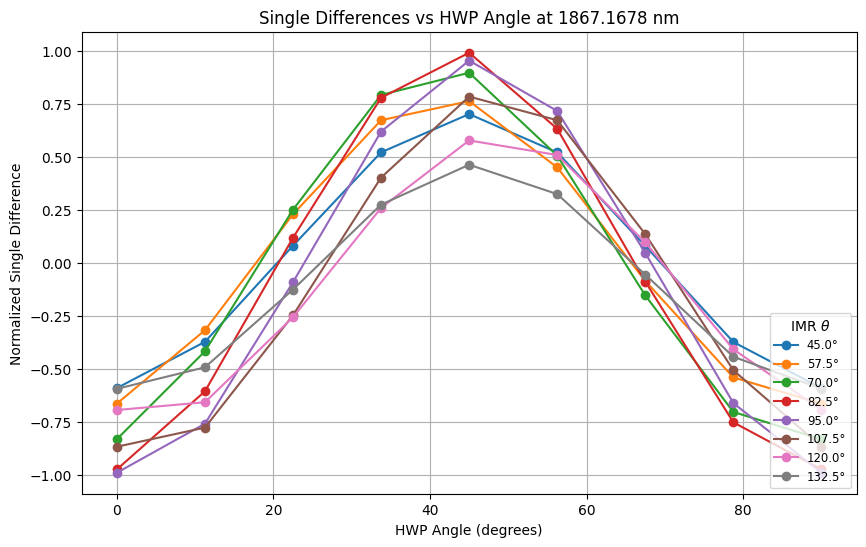

In [7]:
# create plot 

plot_single_differences(csv_path)

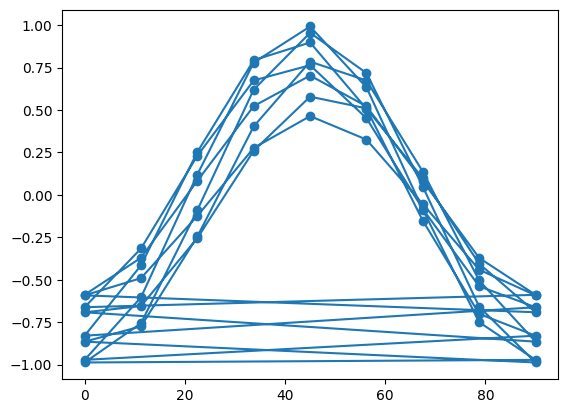

In [11]:
# test Rebecca's code
p = [HWP_retardance(wavelength_bins)[14], IMR_retardance(wavelength_bins)[14]]
system_mm = generate_CHARIS_mueller_matrix(14, 22.5, 125, 'o')
system_parameters = [['hwp', 'phi'], ['image_rotator', 'phi']]
configuration_list = []
imr_angles = [45, 57.5, 70, 82.5, 95, 107.5, 120, 132.5]
hwp_angles = np.linspace(0, 90, 9)
for imr_angle in imr_angles:
    for hwp_angle in hwp_angles:
        config = {
            "image_rotator": {"theta": imr_angle},
            "hwp": {"theta": hwp_angle}
            
        }
        configuration_list.append(config)

LR_intensities = model(p, system_parameters, system_mm, configuration_list)



diffs_sums = process_model(LR_intensities, 'CHARIS')
plt.plot(np.tile(np.linspace(0,90,9), 8), diffs_sums[::2], 'o-')


In [5]:
# test plotting
# generate fake stds
std_diffs = np.repeat(0.02, 9)
std_sums = np.repeat(0.05,9)
interleaved_stds = np.ravel(np.column_stack((std_diffs, std_sums)))

plot_data_and_model(diffs_sums, interleaved_stds, )

NameError: name 'diffs_sums' is not defined

In [5]:
# try new csv function
write_fits_info_to_csv('/Users/thomasmcintosh/Desktop/CHARIS-REU/Cubes_3/cubes', '/Users/thomasmcintosh/Desktop/CHARIS-REU/Raw_3/internal-cal', '/Users/thomasmcintosh/Desktop/CHARIS-REU/Data_visualization_3/csvs/charis_cube_info_bin14.csv', 14)

CSV file written to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_visualization_3/csvs/charis_cube_info_bin14.csv


In [18]:
# try rebeccas csv read func
test_csv = '/Users/thomasmcintosh/Desktop/CHARIS-REU/Data_visualization_3/csvs/charis_cube_info_bin15.csv'
# extract necessary values
read = read_csv(test_csv)
interleaved_values = read[0]
interleaved_stds = read[1]




In [16]:
write_fits_info_to_csv('/Users/thomasmcintosh/Desktop/CHARIS-REU/Cubes_3/cubes','/Users/thomasmcintosh/Desktop/CHARIS-REU/Raw_3/internal-cal', '/Users/thomasmcintosh/Desktop/CHARIS-REU/Data_visualization_3/csvs/charis_cube_info_bin15.csv', 15)


CSV file written to /Users/thomasmcintosh/Desktop/CHARIS-REU/Data_visualization_3/csvs/charis_cube_info_bin15.csv


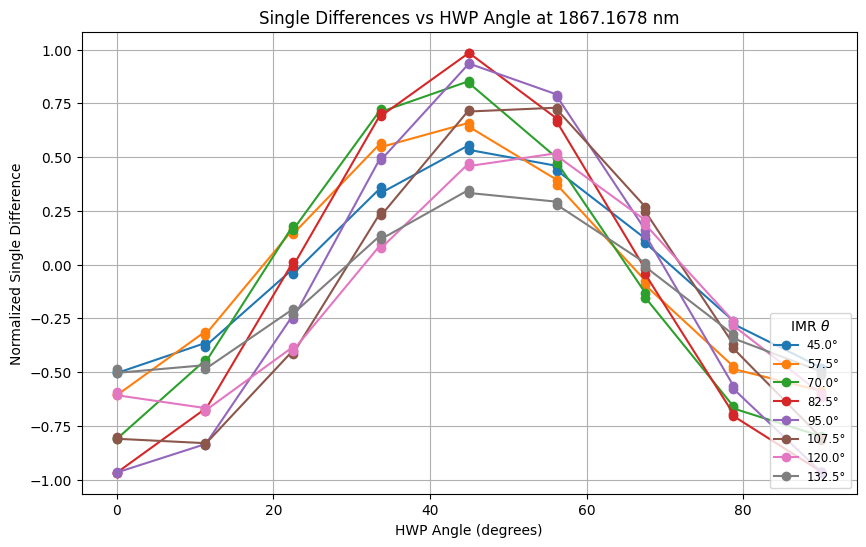

ValueError: Plot save path must end with '.png'.

In [9]:
plot_single_differences('/Users/thomasmcintosh/Desktop/CHARIS-REU/Data_visualization_3/csvs/charis_cube_info_bin14.csv', 'CHARIS')

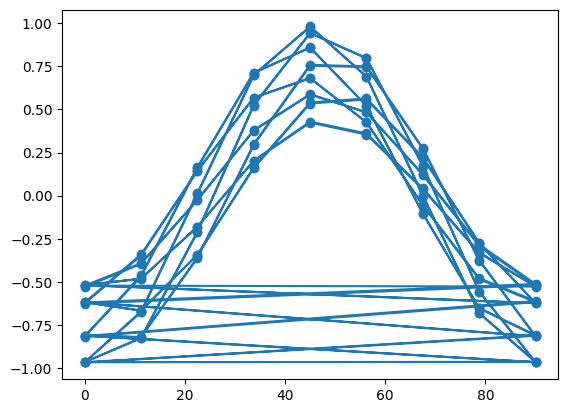

In [20]:
plt.plot(np.tile(np.linspace(0,90,9), 16), interleaved_values[0::2], 'o-')